## Imports packages

In [1]:
import os
import cv2
import math
import torch
%matplotlib inline
import numpy as np
import torch.nn as nn
import collections.abc
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn.utils.spectral_norm as spectral_norm
from PIL import Image
from tqdm import tqdm
from itertools import chain
from itertools import repeat
from torchvision import transforms
from torch.nn.init import constant_
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
from torch.cuda.amp import autocast, GradScaler

## Load Dataset

In [2]:
IMAGE_SIZE = [256,256]

class MonetDataset(Dataset):
    def __init__(self, _path, transform=True):
        self._path = _path
        # Memoize path indices for later
        self.monet_indices = dict()
        self.photo_indices = dict()

        if transform:
            # Default 0-1 norm´
            self.transform = transforms.Compose((
                transforms.Resize(IMAGE_SIZE, antialias=False),
                transforms.ToTensor(),
                
                )
            )
        self.monets = os.listdir(_path + "/monet_jpg")
        self.photos = os.listdir(_path + "/photo_jpg")

        for i, fl in enumerate(self.monets):
            self.monet_indices[i] = fl
        for i, fl in enumerate(self.photos):
            self.photo_indices[i] = fl

    def __len__(self):
        return min(len(self.monets), len(self.photos))

    def __getitem__(self, index):
        random_index = int(np.random.uniform(0, len(self.monet_indices.keys())))
        monet_src = Image.open(os.path.join(self._path, "monet_jpg", self.monet_indices[index % 300]))   
        photo_src = Image.open(os.path.join(self._path, "photo_jpg", self.photo_indices[random_index]))
        monet_src = self.transform(monet_src)
        photo_src = self.transform(photo_src)
        return photo_src, monet_src

path = './data'
dataset = MonetDataset(path)
# Create DataLoader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)


In [3]:
print(len(dataloader))
for epoch in range(1):
    for photo_batch, monet_batch in tqdm(dataloader, desc="Processing Batches", leave=True):
        # photo_batch and monet_batch are tensors of shape [batch_size, 3, H, W]
        print(photo_batch.shape, monet_batch.shape)

19


Processing Batches:  16%|█▌        | 3/19 [00:00<00:00, 24.61it/s]

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


Processing Batches:  32%|███▏      | 6/19 [00:00<00:00, 26.29it/s]

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


Processing Batches:  53%|█████▎    | 10/19 [00:00<00:00, 28.61it/s]

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


Processing Batches: 100%|██████████| 19/19 [00:00<00:00, 29.86it/s]

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])
torch.Size([12, 3, 256, 256]) torch.Size([12, 3, 256, 256])


## Exploratory Data Analysis (EDA)

In [4]:
print("Number of monet paintings: {}".format(len(dataset.monet_indices)))
print("Number of photos: {}".format(len(dataset.photo_indices)))

Number of monet paintings: 300
Number of photos: 7038


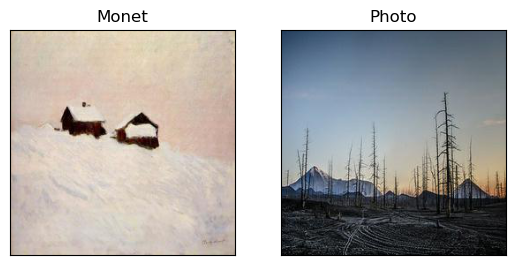

In [5]:
path_monet = os.path.join(path, "monet_jpg")
path_photo = os.path.join(path, "photo_jpg")

random_index = int(np.random.uniform(0, len(dataset.monet_indices)))
example_monet = dataset.monet_indices[random_index]
example_photo = dataset.photo_indices[random_index]

plt.subplot(121)
plt.title('Monet')
plt.imshow(Image.open(os.path.join(path_monet, example_monet)))
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.title('Photo')
plt.imshow(Image.open(os.path.join(path_photo, example_photo)))
plt.xticks([])
plt.yticks([])
plt.show()

Monet:


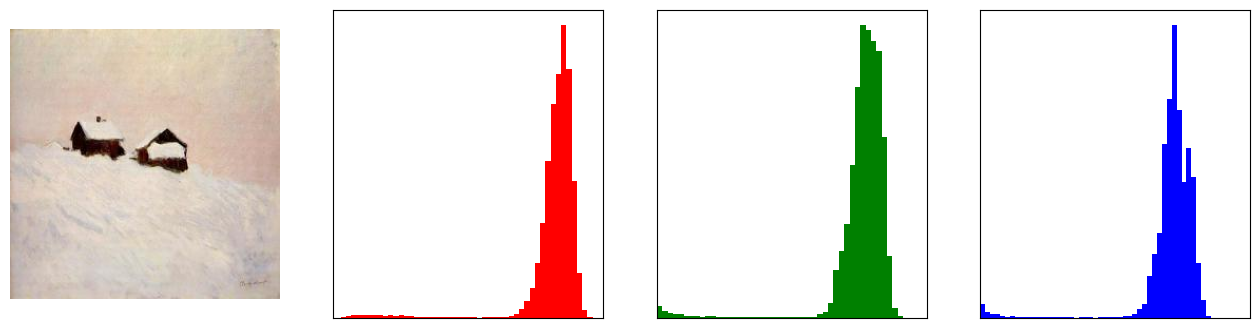

Photo:


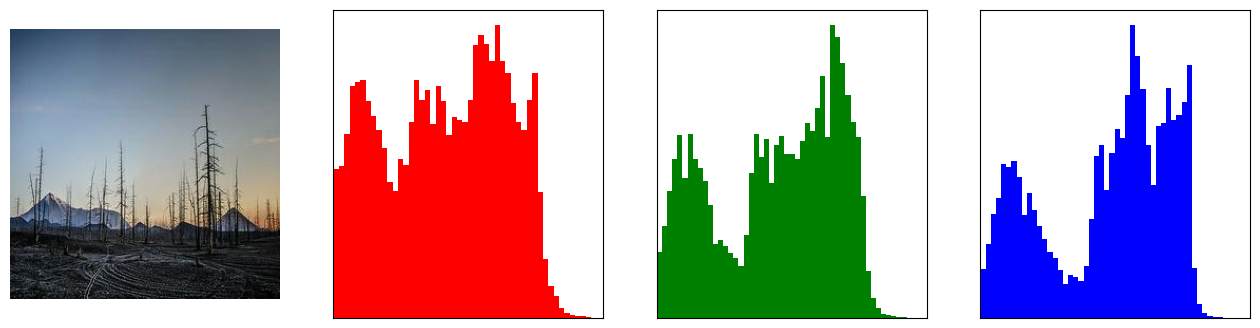

In [6]:
# function to display the present color channels in an image alongside the image itself
def display_color_channels(path):
    plt.figure(figsize=(16, 4))
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis("off")
    
    colors = ["red", "green", "blue"]
    for i in range(len(colors)):
        plt.subplot(1, 4, i + 2)
        plt.hist(
            img[:, :, i].reshape(-1),
            bins=50,
            color=colors[i],
            density=True
        )
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
     
    plt.show()

# show monet example color channels
print("Monet:")
display_color_channels(os.path.join(path_monet, example_monet))
print("Photo:")
display_color_channels(os.path.join(path_photo, example_photo))

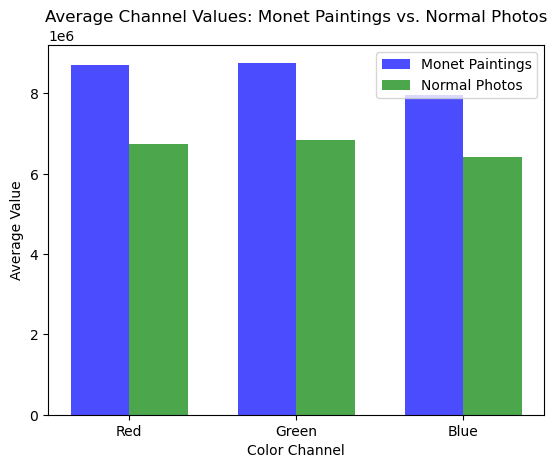

In [7]:
# function to calculate the average channel values (Red, Green, Blue)
def calculate_average_channel_values(image_dir):
    
    # init each channel (R, G, B)
    channel_sum = np.zeros(3) 
    total_images = 0

    for image_filename in os.listdir(image_dir):
        img = Image.open(os.path.join(image_dir, image_filename))
        img_array = np.array(img)
        
        # make sure it is a color image
        if img_array.shape == (256, 256, 3):
            channel_sum += np.sum(img_array, axis=(0, 1))
            total_images += 1

    average_channel_values = channel_sum / total_images
    return average_channel_values

# calculate average channel values
average_monet_values = calculate_average_channel_values(path_monet)
average_photos_values = calculate_average_channel_values(path_photo)

# ceate bar charts to compare average channel values
channels = ['Red', 'Green', 'Blue']
x = np.arange(len(channels))
width = 0.35

plt.bar(x - width/2, average_monet_values, width, label='Monet Paintings', color='b', alpha=0.7)
plt.bar(x + width/2, average_photos_values, width, label='Normal Photos', color='g', alpha=0.7)

plt.xlabel('Color Channel')
plt.ylabel('Average Value')
plt.title('Average Channel Values: Monet Paintings vs. Normal Photos')
plt.xticks(x, channels)
plt.legend()
plt.show()

## Model

### Weight decay

In [8]:
class WeightNormalization(nn.Module):
    def __init__(self, in_channels, epsilon=1e-6):
        super(WeightNormalization, self).__init__()
        self.weights = nn.Parameter(torch.randn(in_channels))  
        self.scaling = nn.Parameter(torch.ones(in_channels)) 
        self.epsilon = epsilon

    def forward(self, x):
        unsqueezed = False
        if x.dim() == 3: 
            x = x.unsqueeze(0) 
            unsqueezed = True
        norm = torch.sqrt(torch.sum(x**2, dim=(2, 3), keepdim=True) + self.epsilon)
        scaled = x / norm
        scaled = scaled * self.scaling.view(
            1, -1, 1, 1
        ) 
        if unsqueezed:  
            scaled = scaled.squeeze(0)

        return scaled

### Fixed smooth convolutions

In [9]:
'''
@inproceedings{kinoshita2020fixed,
author = {Kinoshita, Yuma and Kiya, Hitoshi},
booktitle = {Proceedings of IEEE International Conference on Acoustics, Speech and Signal Processing},
doi = {10.1109/ICASSP40776.2020.9054096},
isbn = {978-1-5090-6631-5},
month = {May},
pages = {3712--3716},
publisher = {IEEE},
title = {{Fixed Smooth Convolutional Layer for Avoiding Checkerboard Artifacts in CNNs}},
url = {https://ieeexplore.ieee.org/document/9054096/},
year = {2020}
}
'''

def _ntuple(n):
    """Translate a float value to n-dim tuple
    Examples
    --------
    >>> a = _ntuple(2)
    >>> a(10)
    (10, 10)
    >>> b = _ntuple(5)
    >>> b(-2)
    (-2, -2, -2, -2, -2)
    Aliases
    -------
    >>> _single(2)
    (2,)
    >>> _pair(2)
    (2, 2)
    >>> _triple(2)
    (2, 2, 2)
    >>> _quadruple(2)
    (2, 2, 2, 2)
    """
    def parse(x):
        if isinstance(x, collections.abc.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse


_single = _ntuple(1)
_pair = _ntuple(2)
_triple = _ntuple(3)
_quadruple = _ntuple(4)


def _generate_hold_kernel(in_channels, zoh_kernel_size, order):
    """Convolve a zero-order hold kernel with the size of *zoh_kernel_size* *order* times
    Examples
    --------
    >>> _generate_hold_kernel(1, 2, 0)
    tensor([[[[1., 1.],
              [1., 1.]]]])
    >>> _generate_hold_kernel(1, 2, 1)
    tensor([[[[1., 2., 1.],
              [2., 4., 2.],
              [1., 2., 1.]]]])
    """
    zoh_kernel_size = _pair(zoh_kernel_size)

    # Zero-order hold kernel
    zoh_kernel = torch.Tensor(1, 1, *zoh_kernel_size)
    constant_(zoh_kernel, 1.0)
    tmp_kernel = zoh_kernel.clone()
    for i in range(order):
        tmp_kernel = F.conv2d(
            tmp_kernel, zoh_kernel, bias=None, stride=(1, 1),
            padding=((zoh_kernel_size[1]+1)//2,
                     (zoh_kernel_size[0]+1)//2),
            dilation=(1, 1), groups=1)
    return torch.repeat_interleave(tmp_kernel, in_channels, dim=0)


class DownSampling2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, 
                 bias=True, padding_mode='zeros',
                 order=0, hold_mode='hold_first', bias_mode='bias_first'):
        super(DownSampling2d, self).__init__()
        self.hold_mode = hold_mode
        self.bias_mode = bias_mode

        if hold_mode == "hold_first":
            hold_in_channels = in_channels
        elif hold_mode == "hold_last":
            hold_in_channels = out_channels
        elif hold_mode == "kernel_conv":
            hold_in_channels = None
        else:
            raise(NotImplementedError())

        if hold_mode == "kernel_conv":
            self.conv = KernelConv2d(
                in_channels, out_channels, kernel_size, stride=stride,
                padding=padding, dilation=dilation, groups=groups,
                bias=bias, padding_mode=padding_mode, order=order)
        elif bias_mode == "bias_first":
            self.hold_conv = HoldConv2d(
                in_channels=hold_in_channels, zoh_kernel_size=stride,
                order=order, stride=1, padding=0, bias=bias,
                padding_mode='zeros')
            self.conv = nn.Conv2d(
                in_channels, out_channels, kernel_size, stride=stride,
                padding=padding, dilation=dilation, groups=groups,
                bias=False, padding_mode=padding_mode)
        elif bias_mode == "bias_last":
            self.hold_conv = HoldConv2d(
                in_channels=hold_in_channels, zoh_kernel_size=stride,
                order=order, stride=1, padding=0, bias=False,
                padding_mode='zeros')
            self.conv = nn.Conv2d(
                in_channels, out_channels, kernel_size, stride=stride,
                padding=padding, dilation=dilation, groups=groups,
                bias=bias, padding_mode=padding_mode)

    def forward(self, x):
        if self.hold_mode == "hold_first":
            x = self.hold_conv(x)
            x = self.conv(x)
        elif self.hold_mode == "hold_last":
            x = self.conv(x)
            x = self.hold_conv(x)
        else:
            x = self.conv(x)

        return x


class HoldConv2d(nn.Module):
    def __init__(self, in_channels, zoh_kernel_size, order=0, stride=1,
                 padding=0, dilation=1, bias=True, padding_mode='zeros'):

        super(HoldConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels
        self.zoh_kernel_size = _pair(zoh_kernel_size)
        self.order = order
        self.stride = _pair(stride)
        self.padding = _pair(padding)
        self.dilation = _pair(dilation)
        self.groups = in_channels
        self.padding_mode = padding_mode

        kernel = _generate_hold_kernel(in_channels,
                                       self.zoh_kernel_size,
                                       self.order)
        self.kernel = Parameter(kernel, requires_grad=False)
        self.kernel_size = self.kernel.size()[2:]

        if bias:
            self.bias = Parameter(torch.Tensor(self.out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.kernel)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        expanded_padding = (self.kernel_size[1] // 2,
                            (self.kernel_size[1]-1) // 2,
                            self.kernel_size[0] // 2,
                            (self.kernel_size[0]-1) // 2)
        input = F.pad(input, expanded_padding)
        if self.padding_mode == 'circular':
            expanded_padding = ((self.padding[1] + 1) // 2, self.padding[1] // 2,
                                (self.padding[0] + 1) // 2, self.padding[0] // 2)
            return F.conv2d(F.pad(input, expanded_padding, mode='circular'),
                            self.kernel, self.bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, self.kernel, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


class KernelConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros', order=0):
        super(KernelConv2d, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            groups, bias, padding_mode)

        self.order = order
        kernel = _generate_hold_kernel(in_channels,
                                       self.stride,
                                       self.order)
        self.hold_kernel = Parameter(kernel, requires_grad=False)
        self.hold_kernel_size = self.hold_kernel.size()[2:]

    def forward(self, input):
        padding = ((self.hold_kernel_size[1]+1)//2,
                   (self.hold_kernel_size[0]+1)//2)
        kernel = F.conv2d(
                    self.weight, self.hold_kernel, bias=None, stride=(1, 1),
                    padding=padding,
                    dilation=(1, 1), groups=self.in_channels)
        kernel_size = kernel.size()[2:]
        expanded_padding = (kernel_size[1] // 2 - padding[1],
                            (kernel_size[1]-1) // 2 - padding[1],
                            kernel_size[0] // 2 - padding[0],
                            (kernel_size[0]-1) // 2 - padding[0])
        input = F.pad(input, expanded_padding)
        if self.padding_mode == 'circular':
            expanded_padding = ((self.padding[1] + 1) // 2, self.padding[1] // 2,
                                (self.padding[0] + 1) // 2, self.padding[0] // 2)
            return F.conv2d(F.pad(input, expanded_padding, mode='circular'),
                            kernel, self.bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, kernel, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


class UpSampling2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, output_padding=1,
                 bias=True, padding_mode='zeros',
                 order=0, hold_mode='hold_first', bias_mode='bias_first'):
        super(UpSampling2d, self).__init__()
        self.hold_mode = hold_mode
        self.bias_mode = bias_mode

        if hold_mode == "hold_first":
            hold_in_channels = in_channels
        elif hold_mode == "hold_last":
            hold_in_channels = out_channels
        elif hold_mode == "kernel_conv":
            raise(NotImplementedError())
        else:
            raise(NotImplementedError())

        if hold_mode == "kernel_conv":
            pass
        elif bias_mode == "bias_first":
            self.hold_conv = HoldConv2d(
                in_channels=hold_in_channels, zoh_kernel_size=stride,
                order=order, stride=1, padding=0, bias=False,
                padding_mode='zeros')
            self.trans_conv = nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride=stride,
                padding=padding, dilation=dilation, groups=groups,
                output_padding=1, bias=bias, 
                padding_mode=padding_mode)
        elif bias_mode == "bias_last":
            self.hold_conv = HoldConv2d(
                in_channels=hold_in_channels, zoh_kernel_size=stride,
                order=order, stride=1, padding=0, bias=bias,
                padding_mode='zeros')
            self.trans_conv = nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride=stride,
                padding=padding, dilation=dilation, groups=groups,
                output_padding=1, bias=False, 
                padding_mode=padding_mode)

    def forward(self, x):
        if self.hold_mode == "hold_first":
            x = self.hold_conv(x)
            x = self.trans_conv(x)
            
        elif self.hold_mode == "hold_last":
            x = self.trans_conv(x)
            x = self.hold_conv(x)
            
        else:
            x = self.trans_conv(x)

        return x 

### Upsampling, downsampling and residual blocks

In [10]:
class ConvolutionalBlock(nn.Module):
    """
        Convolutional blocks for upsampling block and downsampling block 
    """
    def __init__(self,
                 in_channel: int,
                 out_channel: int,
                 is_downsampling: bool = True,
                 add_activation: bool = True,
                 apply_dropout=False,
                 Keep = False,
                 bias = True,
                 **kwarg):
        super(ConvolutionalBlock, self).__init__()
        layers = list()

        # For downsampling blocks and using fixed smooth convolution
        if is_downsampling and not Keep:

            layers.append(DownSampling2d(in_channel, out_channel, **kwarg, dilation=1, groups=1,
                          bias=True, padding_mode="reflect",
                          order=0, hold_mode='hold_last', bias_mode='bias_first'))
            layers.append(nn.InstanceNorm2d(out_channel))
            layers.append(
                WeightNormalization(
                    out_channel,
                )
            )
            layers.append(
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
                if add_activation
                else nn.Identity()
            )
        # For downsampling but only convolution 
        elif is_downsampling and Keep:

            layers.append(nn.Conv2d(
                in_channel, out_channel, padding_mode="reflect",  **kwarg))
            layers.append(nn.InstanceNorm2d(out_channel))
            layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True) if add_activation else nn.Identity())
        # For upsampling and using fixed smooth convolution
        elif not is_downsampling and not Keep:

            layers.append(UpSampling2d(in_channel, out_channel, **kwarg , dilation=1, groups=1,
                           bias=True, padding_mode='zeros',
                           order=0, hold_mode='hold_first', bias_mode='bias_first'))

            layers.append(nn.InstanceNorm2d(out_channel))

            if apply_dropout:
                layers.append(nn.Dropout(0.5))
            layers.append(nn.ReLU(inplace=True) if add_activation else nn.Identity())
        # For Upsampling and but only transposed convolution 
        else:
            layers.append(nn.ConvTranspose2d(in_channel, out_channel, **kwarg))
            layers.append(nn.InstanceNorm2d(out_channel))

            if apply_dropout:
                layers.append(nn.Dropout(0.5))
            layers.append(nn.ReLU(inplace=True) if add_activation else nn.Identity())

        self.ConvB = nn.Sequential(*layers)
    def forward(self, x):
        x = self.ConvB(x)
        return x
    
class ResidualBlock(nn.Module):
    """
        Residual block that learn the residual mapping between
        the input and output of the block 
    """
    def __init__(self,
                 channel: int,
                 **kwarg):
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channel, channel, add_activation=True, Keep =True,apply_dropout=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channel, channel, add_activation=False, Keep =True, kernel_size=3, padding=1),
        )
        
    def forward(self, x):
        return x + self.block(x)


### Network architectures

In [11]:
class Generator(nn.Module):
    """
        Generator 
        Consists of 2 layers of downsampling layer, 
        6 residual blocks and then 2 upsampling layer. 
    """
    
    def __init__(self, 
                 input_channel: int, 
                 features: int = 64, 
                 num_residuals: int = 6):
        super().__init__()
        self.first_layer = nn.Sequential(
            DownSampling2d(input_channel, features, kernel_size=7, stride=1, padding=3, dilation=1, groups=1,
                          bias=True, padding_mode="reflect",
                          order=0, hold_mode='hold_last', bias_mode='bias_first'),
            nn.InstanceNorm2d(features),
            nn.ReLU(inplace=True),
        )
        self.downsampling_layer = nn.Sequential(
            ConvolutionalBlock(features, features*2, is_downsampling = True, add_activation= True, apply_dropout=True, kernel_size=3, stride=2, padding=1),
            ConvolutionalBlock(features*2, features*4, is_downsampling = True, add_activation= True, Keep =True, apply_dropout=True, kernel_size=3, stride=2, padding=1)
        )
        self.residual_layer = nn.Sequential(
            *[ResidualBlock(features * 4) for _ in range(num_residuals)]
        )
        self.upsampling_layer = nn.Sequential(
            ConvolutionalBlock(features*4, features*2, is_downsampling = False, add_activation= True, Keep = True,kernel_size=3, stride=2, padding=1, output_padding=1),
            ConvolutionalBlock(features*2, features, is_downsampling = False, add_activation= True, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        self.last_layer = nn.Sequential(
            nn.Conv2d(features, input_channel, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.Tanh()
        )
    
    def forward(self, x):

        x = self.first_layer(x)
        x = self.downsampling_layer(x)
        x = self.residual_layer(x)
        x = self.upsampling_layer(x)
        x = self.last_layer(x)
        return x


In [12]:
class Discriminator(nn.Module):
    """
        Discriminator 
        Consists of 3 Convolution-InstanceNorm-LeakyReLU block
    """

    def __init__(self, 
                 input_channel: int, 
                 features: int = 64, 
                 num_layers: int = 4):
        super().__init__()

        layers = list()
        layers.append(spectral_norm(nn.Conv2d(input_channel, features, kernel_size=4, stride=2, padding=1, padding_mode="reflect")))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        for i in range(1, num_layers):
            in_channel = features * 2 ** (i-1)
            out_channel = in_channel * 2

            if i == num_layers - 1:
                layers.append(self.Convlayer(in_channel, out_channel, 4, 1))
            else:
                layers.append(self.Convlayer(in_channel, out_channel, 4, 2))

        layers.append(nn.Conv2d(out_channel, 1, kernel_size=4, stride=1, padding=1))
        layers.append(nn.Sigmoid())  

        self.Disc = nn.Sequential(*layers)

    def Convlayer(self, in_ch, out_ch, kernel_size, stride, use_leaky=True, use_inst_norm=True, use_pad=True):
        if use_pad:
            conv = spectral_norm(nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True, padding_mode="reflect"))
        else:
            conv = spectral_norm(nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True, padding_mode="reflect"))

        if use_leaky:
            actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            actv = nn.ReLU(inplace=True)

        if use_inst_norm:
            norm = nn.InstanceNorm2d(out_ch)
        else:
            norm = nn.BatchNorm2d(out_ch)

        return nn.Sequential(conv, norm, actv)
    
    def forward(self, x):
        return self.Disc(x)

In [ ]:
from torchmetrics.image.mifid import MemorizationInformedFrechetInceptionDistance
class Model(torch.nn.Module):
    def __init__(self, epochs, device, cycle_lambda = 10, Learning_rate=2e-4):
        super(Model,self).__init__()
        self.device = device
        
        self.gen_monet2photo = Generator(input_channel=3).to(self.device)
        self.gen_photo2monet = Generator(input_channel=3).to(self.device)
        self.disc_monet = Discriminator(input_channel=3).to(self.device)
        self.disc_photo = Discriminator(input_channel=3).to(self.device)

        # Optimizer for the generator and discriminators
        self.opt_gen = torch.optim.Adam(chain(self.gen_monet2photo.parameters(), self.gen_photo2monet.parameters()),
                                         lr = Learning_rate,
                                         betas= (0.5, 0.999))
        self.opt_disc = torch.optim.Adam(chain(self.disc_monet.parameters(), self.disc_photo.parameters()),
                                         lr = Learning_rate,
                                         betas= (0.5, 0.999))
        
        self.L1 = nn.L1Loss().to(self.device)
        self.mse = nn.MSELoss().to(self.device) 
        
        self.mifid = MemorizationInformedFrechetInceptionDistance(feature=64).to(device)
        self.cycle_lambda = cycle_lambda
        self.epochs = epochs

        self.D_scaler = GradScaler()
        self.G_scaler = GradScaler()
        
        self.zero_tensor = None
        self.Tensor = torch.FloatTensor
    def init_weights(self):
        pass

    # Generate and add noise to the inputs of the discriminator
    def add_noise(self, tensor, noise_level=0.05):
        """
        Adds Gaussian noise to the input tensor.
        Args:
            tensor (torch.Tensor): Input tensor to which noise will be added.
            noise_level (float): Standard deviation of the Gaussian noise.
        Returns:
            torch.Tensor: Tensor with added noise.
        """
        if noise_level > 0:
            noise = torch.randn_like(tensor) * noise_level
            return tensor + noise
        return tensor
    
    """ From https://github.com/NVlabs/SPADE/blob/master/models/networks/loss.py """
    def get_zero_tensor(self, input):
        if self.zero_tensor is None:
            self.zero_tensor = self.Tensor(1).fill_(0)
            self.zero_tensor.requires_grad_(False)
        return self.zero_tensor.expand_as(input)
    def hinge_loss(self, input, target_is_real, for_discriminator = False):
        if for_discriminator:
            if target_is_real:
                minval = torch.min(input - 1, self.get_zero_tensor(input))
                loss = -torch.mean(minval)
            else:
                minval = torch.min(-input - 1, self.get_zero_tensor(input))
                loss = -torch.mean(minval)
        else:
            assert target_is_real, "The generator's hinge loss must be aiming for real"
            loss = -torch.mean(input)
        return loss
    
    def train(self, dataloader):
        for epoch in range(self.epochs):
            avg_G_loss = 0.0
            avg_D_loss = 0.0

            reals = 0
            fakes = 0
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))
            #loop = tqdm(dataloader, leave=True, total=len(dataloader))
            noise_level = max(0.05, 0.05 * (1 - epoch / self.epochs))

            monet_list = []
            generated_monet_list = []
            photo_list = []
            generated_photo_list = []
    
            for photo_batch, monet_batch in tqdm(dataloader, desc="Processing Batches", leave=True):
                photo_batch, monet_batch = photo_batch.to(self.device), monet_batch.to(self.device)
                
                # Train discriminators Between photo and monet
                with autocast():
                    # Generate fake photo to train photos discriminator 
                    fake_photo = self.gen_monet2photo(monet_batch)
                    D_photo = self.disc_photo(self.add_noise(photo_batch, noise_level))
                    D_fake_photo = self.disc_photo(self.add_noise(fake_photo.detach(), noise_level))
                    reals += D_photo.mean().item()
                    fakes += D_fake_photo.mean().item()
                    # Use the hinge loss between the discriminator output
                    # and the label (Real photo is 1 and the generated one is 0)
                    D_real_photo_loss = self.mse(D_photo, torch.ones_like(D_photo))
                    D_fake_photo_loss = self.mse(D_fake_photo, torch.zeros_like(D_fake_photo))

                    D_photo_loss = (D_real_photo_loss + D_fake_photo_loss) / 2

                    # Generate fake monet pictures to train monets discriminator
                    fake_monet = self.gen_photo2monet(photo_batch)
                    D_monet = self.disc_monet(self.add_noise(monet_batch, noise_level))
                    D_fake_monet = self.disc_monet(self.add_noise(fake_monet.detach(), noise_level))
                    # Use the mean squared error between the discriminator output
                    # and the label (Real monet is 1 and the generated monet is 0)
                    D_real_monet_loss = self.mse(D_monet, torch.ones_like(D_monet))
                    D_fake_monet_loss = self.mse(D_fake_monet, torch.zeros_like(D_fake_monet))
                    D_monet_loss = (D_real_monet_loss + D_fake_monet_loss) / 2
                    total_D_loss = D_monet_loss + D_photo_loss
                    avg_D_loss += total_D_loss.item()
                self.opt_disc.zero_grad()
                self.D_scaler.scale(total_D_loss).backward()  
                self.D_scaler.step(self.opt_disc)  
                self.D_scaler.update() 
                

                # Train generators for photo and monet images
                with autocast():

                    # adversarial losses
                    # D_fake_photo = self.disc_photo(self.add_noise(fake_photo.detach(), noise_level))
                    # D_fake_monet = self.disc_monet(self.add_noise(fake_monet.detach(), noise_level))
                    # G_fake_photo_loss = self.hinge_loss(D_fake_photo, True, False)
                    # G_fake_monet_loss = self.hinge_loss(D_fake_monet, True, False)

                    # cycle losses
                    cycle_monet = self.gen_photo2monet(fake_photo)
                    cycle_photo = self.gen_monet2photo(fake_monet)
                   
                    cycle_monet_loss = self.L1(monet_batch, cycle_monet)
                    cycle_photo_loss = self.L1(photo_batch, cycle_photo)

                    # MiFID loss
                    # Monet
                    # Normalize to [0, 255]
                    monet = (monet_batch * 255).clamp(0, 255).to(torch.uint8)
                    fake_monet = (fake_monet * 255).clamp(0, 255).to(torch.uint8)
                    # Update MiFID with real and generated images
                    self.mifid.update(monet * 255, real=True)
                    self.mifid.update(fake_monet.detach() * 255, real=False)
                    monet_mifid_loss = self.mifid.compute().item()
                    self.mifid.reset()
                    # Photo
                    # Normalize to [0, 255]
                    photo = (photo_batch * 255).clamp(0, 255).to(torch.uint8)
                    fake_photo = (fake_photo * 255).clamp(0, 255).to(torch.uint8)
                    # Update MiFID with real and generated images
                    self.mifid.update(photo * 255, real=True)
                    self.mifid.update(fake_photo.detach() * 255, real=False)
                    photo_mifid_loss = self.mifid.compute().item()
                    self.mifid.reset()

                    # total loss
                    total_G_loss = (
                        # G_fake_photo_loss
                        # + G_fake_monet_loss
                        photo_mifid_loss
                        + monet_mifid_loss
                        + cycle_monet_loss * self.cycle_lambda
                        + cycle_photo_loss * self.cycle_lambda
                        
                    )
                    avg_G_loss += total_G_loss.item()
                    
                self.opt_gen.zero_grad()
                self.G_scaler.scale(total_G_loss).backward()  
                self.G_scaler.step(self.opt_gen)  
                self.G_scaler.update()
            print("Generator Loss:%f  -  Discriminator Loss:%f" % (avg_G_loss, avg_D_loss))
            
    def test(self, photo, monet):
        results = []
        
        photo, monet = photo.to(self.device), monet.to(self.device)

        generated_monet = self.gen_photo2monet(photo)

        # Pass the monet and generated images through the discriminator
        generated_score = self.disc_monet(generated_monet.detach())
        real_score = self.disc_monet(monet)
        generated_score = generated_score.mean().item()
        real_score = real_score.mean().item()
        
        results.append({
            "generated_score": generated_score,
            "real_score": real_score,
            "generated_image": generated_monet.detach().cpu()  # Detach and move to CPU
        })
        return results
        

## Training

In [ ]:
gan = Model(1, 'cpu')
gan.train(dataloader)

/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_15826/1552898077.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.D_scaler = GradScaler()
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_15826/1552898077.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.G_scaler = GradScaler()



Epoch 1/1


Processing Batches:   0%|          | 0/19 [00:00<?, ?it/s]/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_15826/1552898077.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/z2/m5_kp65x4ydbtt3mq8bcpw_r0000gn/T/ipykernel_15826/1552898077.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Processing Batches:  74%|███████▎  | 14/19 [21:41<07:43, 92.74s/it]

## Test

In [ ]:
monet_list = []
generated_list = []
photo_list = []
loop = tqdm(dataset, leave=True, total=len(dataset))
for i, (photo, monet) in enumerate(loop):
    if i >= len(dataset) - 1:  # Ensure no more than the intended batches
        break

    result = gan.test(photo, monet)
    generated_list.append(result[0]["generated_image"])
    monet_list.append(monet)
    photo_list.append(photo)

100%|█████████▉| 299/300 [01:27<00:00,  3.41it/s]


## Compare results before and after training

### Before Training

In [ ]:
images = photo_list[0]
monet = monet_list[0]

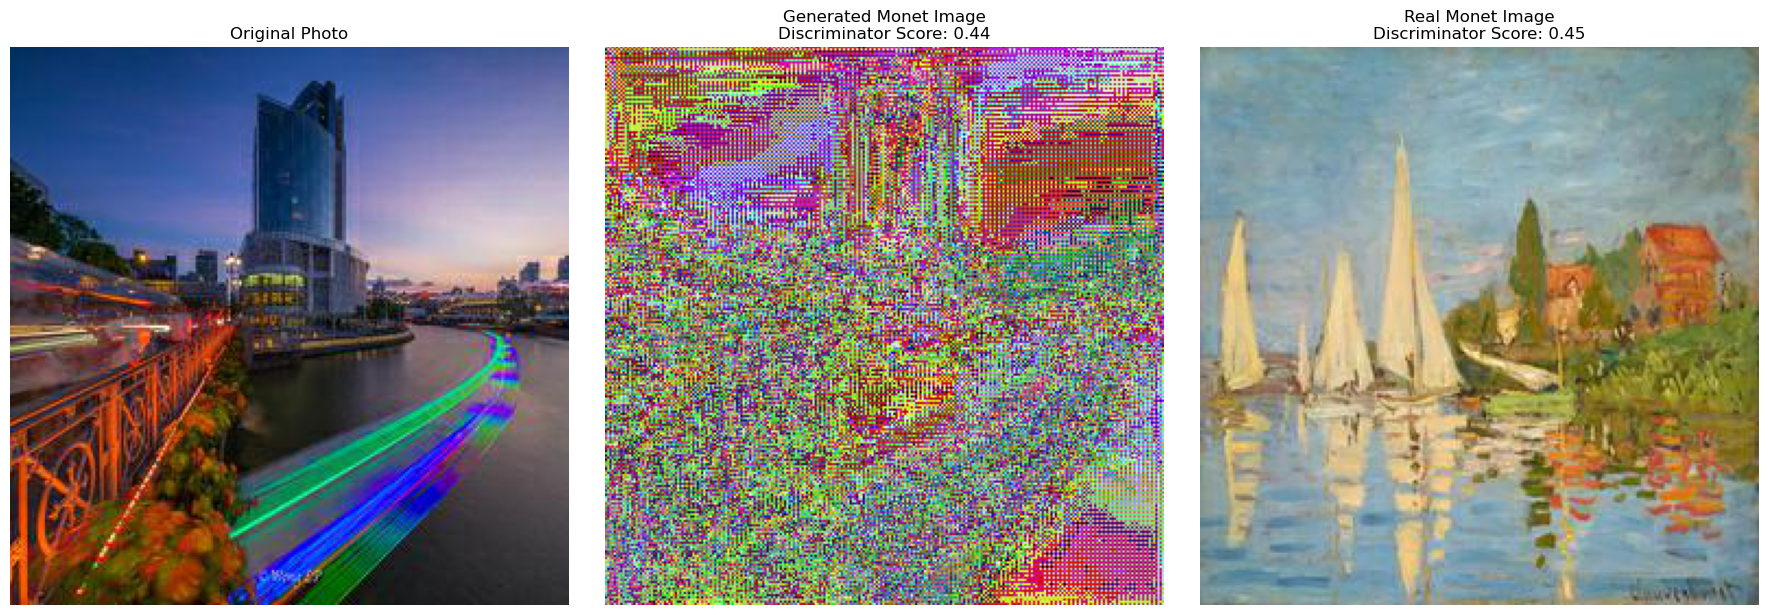

In [ ]:
generator = Generator(input_channel=3)
generated_monet = generator(images)

discriminator = Discriminator(input_channel=3)
# Pass the monet and generated images through the discriminator
generated_score = discriminator(generated_monet)
real_score = discriminator(monet)
generated_score = generated_score.mean().item()
real_score = real_score.mean().item()

# Plotting the real photo, generated Monet-like image, and discriminator scores
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original photo
axes[0].imshow(transforms.ToPILImage()(images.cpu().squeeze()))
axes[0].set_title("Original Photo")
axes[0].axis('off')

# Generated Monet-like image
axes[1].imshow(transforms.ToPILImage()(generated_monet))
axes[1].set_title(f"Generated Monet Image\nDiscriminator Score: {generated_score:.2f}")
axes[1].axis('off')

# Real Monet painting with discriminator score
axes[2].imshow(transforms.ToPILImage()(monet.cpu().squeeze()))
axes[2].set_title(f"Real Monet Image\nDiscriminator Score: {real_score:.2f}")
axes[2].axis('off')

plt.tight_layout()
plt.show()

### After training

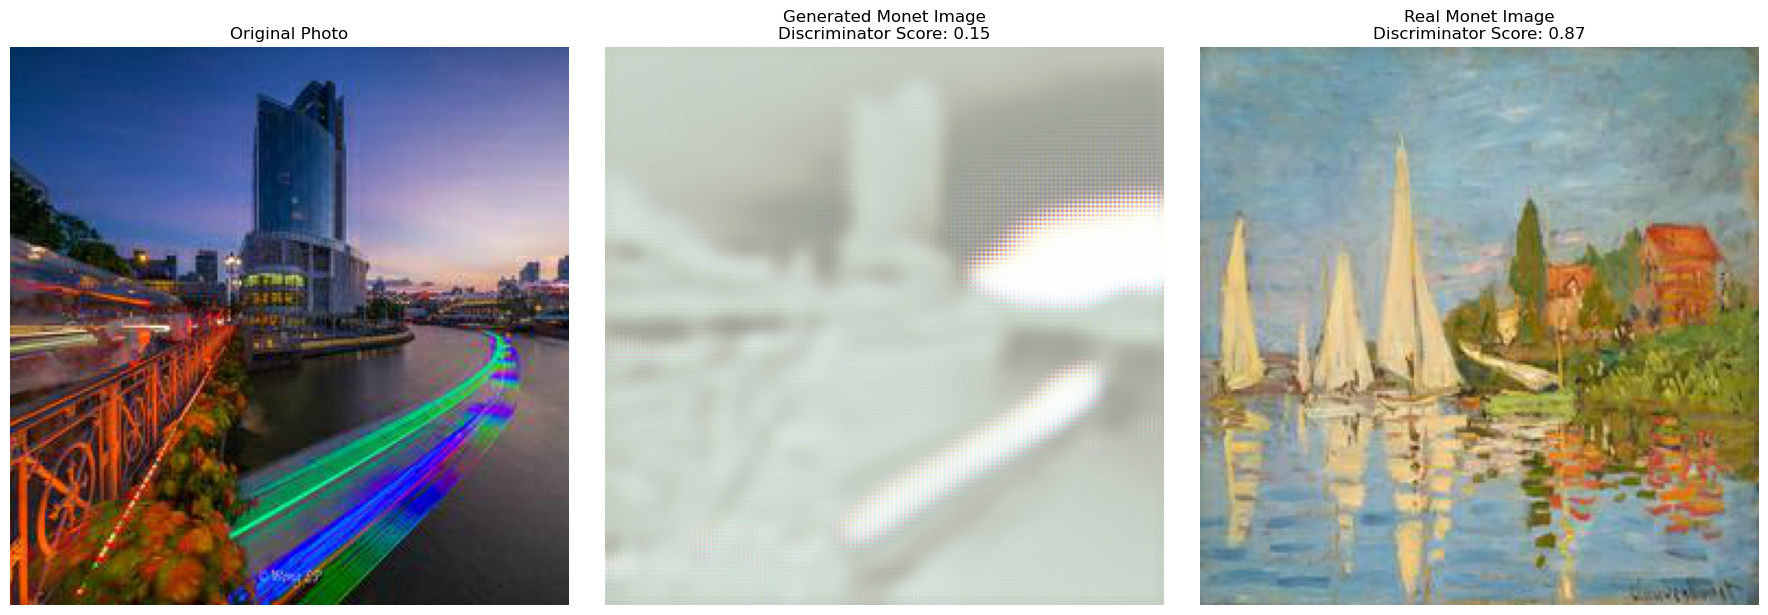

In [ ]:
result = gan.test(images, monet)

# Pass the monet and generated images through the discriminator
generated_monet = result[0]["generated_image"]
generated_score = result[0]["generated_score"]
real_score =result[0]["real_score"]
generated_monet =generated_monet .permute(1, 2, 0).numpy() * 0.5 + 0.5 
# img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)


# Plotting the real photo, generated Monet-like image, and discriminator scores
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original photo
axes[0].imshow(transforms.ToPILImage()(images.cpu().squeeze()))
axes[0].set_title("Original Photo")
axes[0].axis('off')

# Generated Monet-like image
axes[1].imshow(transforms.ToPILImage()(generated_monet))
axes[1].set_title(f"Generated Monet Image\nDiscriminator Score: {generated_score:.2f}")
axes[1].axis('off')

# Real Monet painting with discriminator score
axes[2].imshow(transforms.ToPILImage()(monet.cpu().squeeze()))
axes[2].set_title(f"Real Monet Image\nDiscriminator Score: {real_score:.2f}")
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Evaluate with MI-FID

In [ ]:
from torchmetrics.image.mifid import MemorizationInformedFrechetInceptionDistance

# Stack images into tensors
monet_tensor = torch.cat([img.unsqueeze(0) for img in monet_list]) 
generated_tensor = torch.cat([img.unsqueeze(0) for img in generated_list])  

# Normalize to [0, 255]
monet_tensor = (monet_tensor * 255).clamp(0, 255).to(torch.uint8)
generated_tensor = (generated_tensor * 255).clamp(0, 255).to(torch.uint8)

# Initialize MiFID
mifid = MemorizationInformedFrechetInceptionDistance(feature=64)

mifid.update(monet_tensor, real=True)
mifid.update(generated_tensor, real=False)

print("MI-FID: ", mifid.compute())

** On entry to DGEBAL, parameter number  3 had an illegal value
** On entry to DGEHRD, parameter number  2 had an illegal value
** On entry to DHSEQR, parameter number  4 had an illegal value


/opt/anaconda3/lib/python3.12/site-packages/torchmetrics/image/mifid.py:220: UserWarning: cov(): degrees of freedom is <= 0. Correction should be strictly less than the number of observations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Correlation.cpp:116.)
  cov_real, cov_fake = torch.cov(real_features.t()), torch.cov(fake_features.t())


RuntimeError: false INTERNAL ASSERT FAILED at "/Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp":1538, please report a bug to PyTorch. torch.linalg.eigvals: Argument 4 has illegal value. Most certainly there is a bug in the implementation calling the backend library.